# Hip - Implant : Image Classification using CNN (Version 2)

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import imghdr
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

2023-12-19 10:57:18.471142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

2023-12-19 10:57:20.540760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 10:57:20.544073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 10:57:20.555318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
REGION = "us-central1"

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

BUCKET_NAME = f"gs://{PROJECT_ID}-hip-implant"

os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["REGION"] = REGION

In [6]:
!gsutil ls | grep ^{BUCKET_NAME}/$ || gsutil mb -l {REGION} {BUCKET_NAME}

gs://qwiklabs-asl-04-06351f77b64f-hip-implant/


In [7]:
data = tf.keras.utils.image_dataset_from_directory(f"gs://qwiklabs-asl-04-06351f77b64f-hip-implant/")

Found 206 files belonging to 2 classes.


2023-12-19 10:57:39.828103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 10:57:39.830241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 10:57:39.832167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
data_itr = data.as_numpy_iterator()

2023-12-19 10:57:41.340487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [206]
	 [[{{node Placeholder/_0}}]]
2023-12-19 10:57:41.341048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]


In [9]:
data_itr

In [10]:
batch = data_itr.next()

In [11]:
len(batch)

2

In [12]:
batch[0].shape # feature

(32, 256, 256, 3)

In [13]:
batch[1] #labels

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0], dtype=int32)

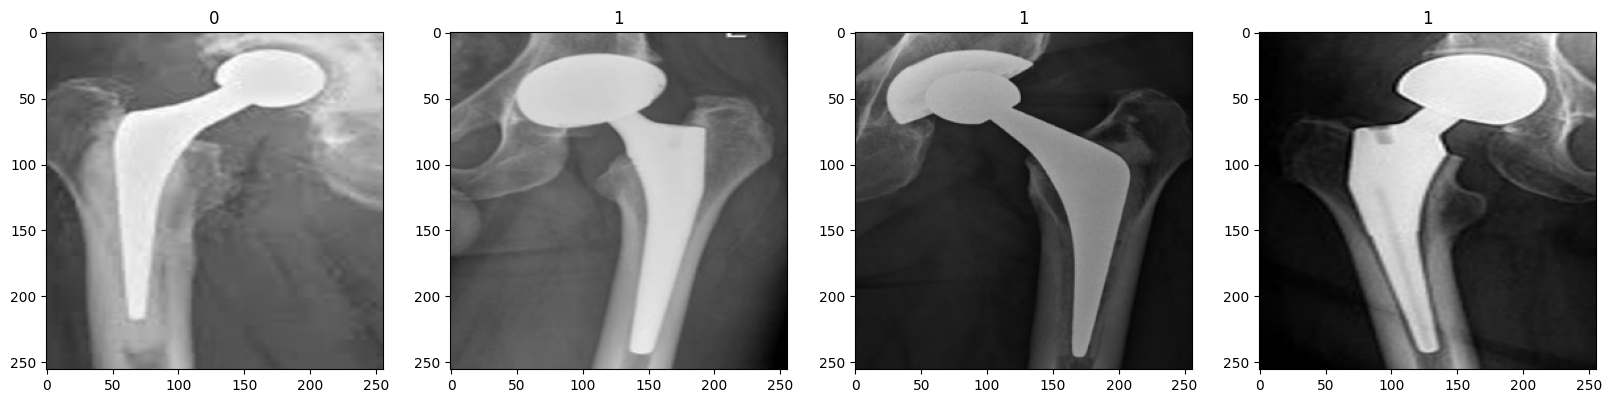

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Preprocessing**

In [15]:
data = data.map(lambda x, y: (x/255, y)) # x = images, y = labels

In [16]:
batch = data.as_numpy_iterator().next()

2023-12-19 10:57:46.378421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [206]
	 [[{{node Placeholder/_0}}]]
2023-12-19 10:57:46.379027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [206]
	 [[{{node Placeholder/_0}}]]


In [17]:
batch[0].min()

0.0

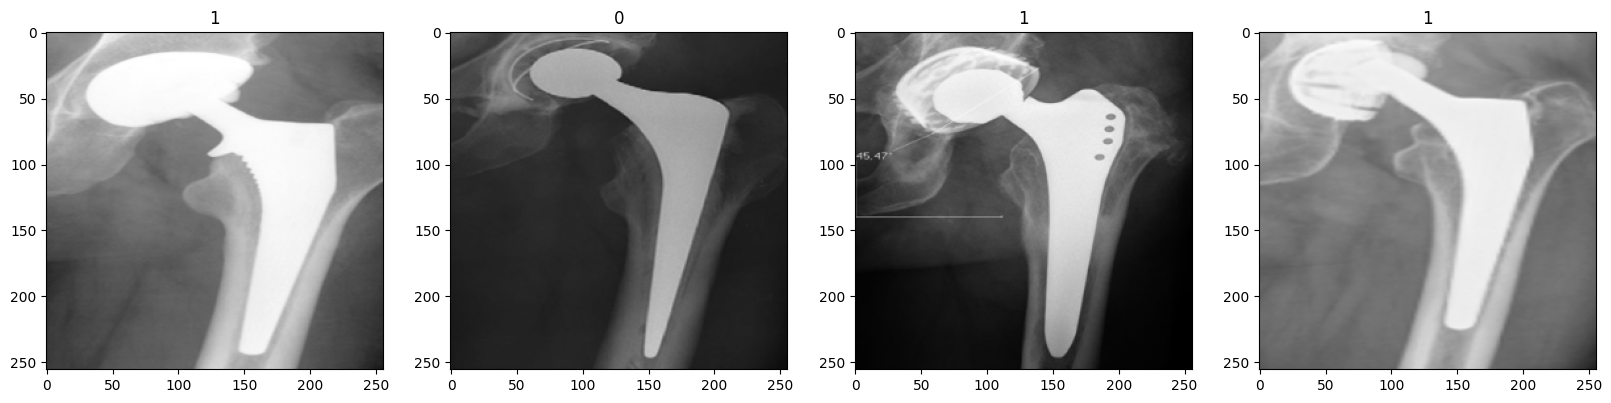

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

**Split data**

In [19]:
len(data)

7

In [20]:
train_size = int(len(data)*.7)
print(train_size)
val_size = int(len(data)*.2)+1
print(val_size)
test_size = int(len(data)*.1)+1
print(test_size)

4
2
1


In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

**Build Model**

In [22]:
model = Sequential([
    Conv2D(name="First-Conv2D-layer",filters=16, kernel_size=3, strides=1, input_shape=(256, 256, 3), activation='relu'),
    MaxPooling2D(name="First-pooling-layer"),
    
    Conv2D(name="Second-Conv2D-layer", filters=32, kernel_size=3, strides=1, activation='relu'),
    MaxPooling2D(name="Second-pooling-layer"),
    
    Conv2D(name="Third-Conv2D-layer", filters=16, kernel_size=3, strides=1, activation='relu'),
    MaxPooling2D(name="Third-pooling-layer"),
    
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First-Conv2D-layer (Conv2D)  (None, 254, 254, 16)     448       
                                                                 
 First-pooling-layer (MaxPoo  (None, 127, 127, 16)     0         
 ling2D)                                                         
                                                                 
 Second-Conv2D-layer (Conv2D  (None, 125, 125, 32)     4640      
 )                                                               
                                                                 
 Second-pooling-layer (MaxPo  (None, 62, 62, 32)       0         
 oling2D)                                                        
                                                                 
 Third-Conv2D-layer (Conv2D)  (None, 60, 60, 16)       4624      
                                                        

In [25]:
logdir = 'logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-12-19 10:57:51.762518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]
2023-12-19 10:57:51.763165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]
2023-12-19 10:57:57.382238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-12-19 10:57:58.429730: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4433a8c180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-

3/4 [=====================>........] - ETA: 0s - loss: 0.7001 - accuracy: 0.5000 

2023-12-19 10:58:00.648989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]
2023-12-19 10:58:00.649507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]


4/4 [==============================] - 13s 2s/step - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.7550 - val_accuracy: 0.4219
Epoch 2/20
4/4 [==============================] - 8s 1s/step - loss: 0.7158 - accuracy: 0.4766 - val_loss: 0.6928 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 8s 1s/step - loss: 0.6889 - accuracy: 0.5469 - val_loss: 0.6856 - val_accuracy: 0.5469
Epoch 4/20
4/4 [==============================] - 8s 1s/step - loss: 0.6904 - accuracy: 0.5703 - val_loss: 0.6748 - val_accuracy: 0.5781
Epoch 5/20
4/4 [==============================] - 8s 1s/step - loss: 0.6888 - accuracy: 0.5625 - val_loss: 0.6820 - val_accuracy: 0.5781
Epoch 6/20
4/4 [==============================] - 8s 1s/step - loss: 0.6903 - accuracy: 0.5078 - val_loss: 0.6825 - val_accuracy: 0.5469
Epoch 7/20
4/4 [==============================] - 8s 1s/step - loss: 0.6872 - accuracy: 0.5078 - val_loss: 0.6958 - val_accuracy: 0.3594
Epoch 8/20
4/4 [==============================] - 8

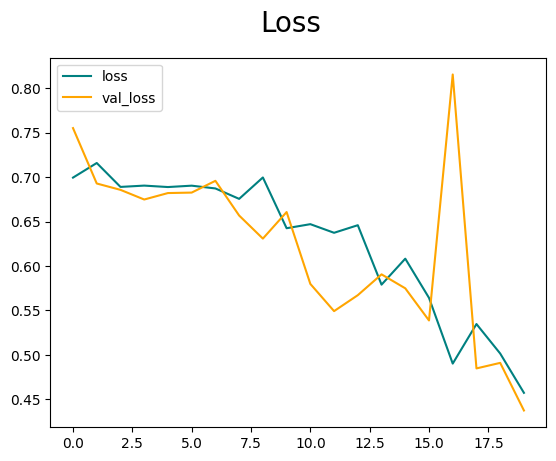

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Evaluate Performance

In [29]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-12-19 11:00:41.614228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]
2023-12-19 11:00:41.614822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [206]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 325ms/step


In [31]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 0.8571428656578064, Recall: 0.8571428656578064, Accuracy: 0.8571428656578064


# Test

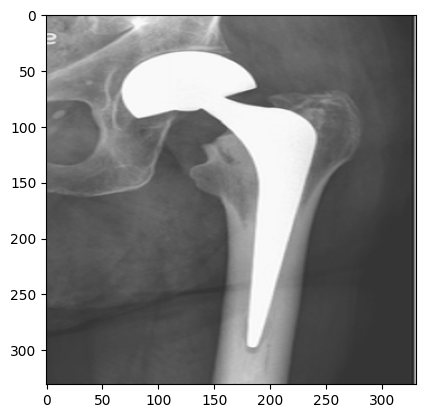

In [32]:
img = cv2.imread(f"control (9).png")
plt.imshow(img)
plt.show()

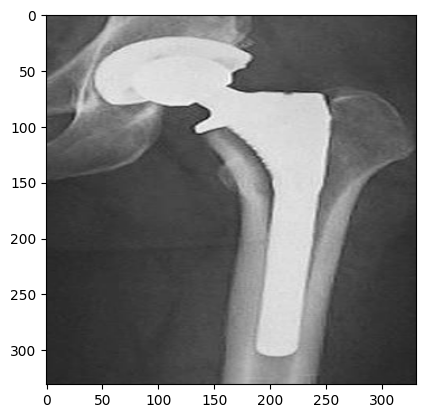

In [33]:
img = cv2.imread(f"loose (10).png")
plt.imshow(img)
plt.show()

In [34]:
def model_prediction(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    resize = tf.image.resize(img, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    if(yhat>0.5):
        print("Prediction is loose")
    else:
        print("Prediction is control")

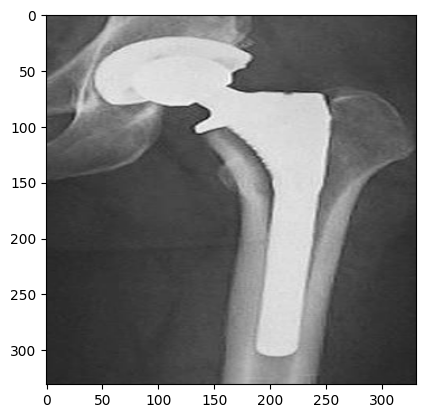

1/1 [==============================] - 0s 96ms/step
Prediction is loose


In [35]:
model_prediction(f"loose (10).png")

In [36]:
from google.cloud import storage
client = storage.Client()
bucket = client.get_bucket(f"qwiklabs-asl-04-06351f77b64f-hip-implant")
blob = bucket.get_blob(f"Control/control (1).png")

In [37]:
from IPython.display import Image
image=Image(blob.download_as_bytes())

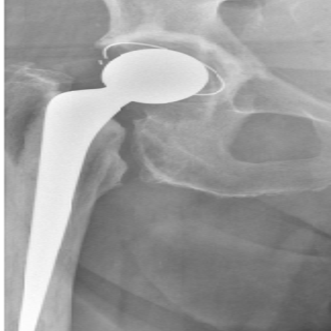

In [38]:
image

In [39]:
from huggingface_hub import notebook_login
notebook_login()

**Saving the model locally**

In [42]:
from tensorflow.keras.models import save_model
save_model(model, "hip_impant_model.h5")